# **Pharmaceutical Sales prediction across multiple stores**

**Forecasting Sales is a essential use of Machine Learning(ML).Sales forecasts can be used to identify benchmarks and determine incremental impacts of new initiatives, plan resources in response to expected demand and project future budgets.**

## **Table of contents**
     1. Exploring the data and Data Pre-processing
     2. Building models with sklearn pipelines
     3. Choose a loss function
     4. Post Prediction analysis
     5. Serialize models

 ## **1. Data Preprocessing**

  1.1 Importing Libraries

In [ ]:
!pip install category_encoders
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import  RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn import model_selection
import numpy as np 
import matplotlib.pyplot as plt
import category_encoders as ce
%matplotlib inline

In [2]:
train_data=pd.read_csv('/content/drive/My Drive/Output.csv')

In [3]:
train_data.head()

,Weekdays,Weeks,Months,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Store-1,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,23,6,867,3,6/3/2015,5608,469,1,1,0.0,0,867,d,c,21810.0,9.0,2012.0,0,NaN,NaN,"Jan,Apr,Jul,Oct"
1,1,23,6,868,3,6/3/2015,13500,816,1,1,0.0,0,868,d,c,1360.0,8.0,2005.0,1,10.0,2014.0,"Jan,Apr,Jul,Oct"
2,1,23,6,869,3,6/3/2015,7007,932,1,1,0.0,0,869,c,a,230.0,10.0,2001.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,1,23,6,870,3,6/3/2015,7911,971,1,1,0.0,0,870,a,a,780.0,4.0,2009.0,0,NaN,NaN,"Jan,Apr,Jul,Oct"
4,1,23,6,871,3,6/3/2015,9198,678,1,1,0.0,0,871,d,c,10620.0,NaN,NaN,0,NaN,NaN,"Jan,Apr,Jul,Oct"


**1.2 Cleansing the Data**

   1.2.1 Handling Null values

In [4]:
#Checking the no. of NaN values
train_data.isna().sum()

Weekdays                          0
Weeks                             0
Months                            0
Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                  31050
SchoolHoliday                     0
Store-1                           0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                     0
dtype: int64

1) CompetitionDistance:

* Before deciding how to treat this,we know there are infinite ways of filling missing values.
* The most common and simplistic approach is to fill it with either the mean or the median of this variable.
* Let's quickly have a look at those metrics.

{'Mean': 5430.085652302903, 'Median': 2330.0, 'Standard Dev': 7715.31989799512}

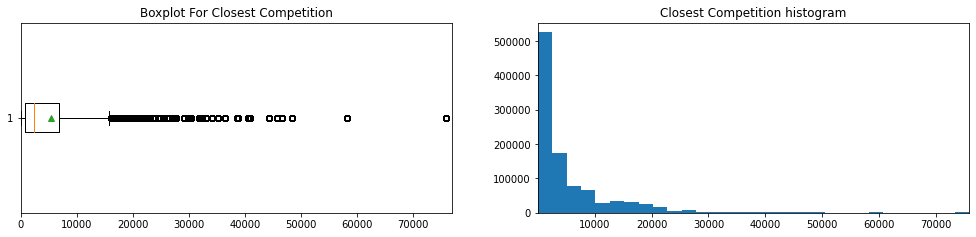

In [5]:
df_store_check_distribution=train_data.drop(train_data[pd.isnull(train_data.CompetitionDistance)].index)
fig, axes = plt.subplots(1, 2, figsize=(17,3.5))
axes[0].boxplot(df_store_check_distribution.CompetitionDistance, showmeans=True,vert=False,)
axes[0].set_xlim(0,max(df_store_check_distribution.CompetitionDistance+1000))
axes[0].set_title('Boxplot For Closest Competition')
axes[1].hist(df_store_check_distribution.CompetitionDistance, cumulative=False, bins=30)
axes[1].set_title("Closest Competition histogram")
axes[1].set_xlim((min(df_store_check_distribution.CompetitionDistance), max(df_store_check_distribution.CompetitionDistance)))
{"Mean":np.nanmean(train_data.CompetitionDistance),"Median":np.nanmedian(train_data.CompetitionDistance),"Standard Dev":np.nanstd(train_data.CompetitionDistance)}#That's what i thought, very different values, let's see why 

We see a highly right skewed distribution for this variable with a significant difference between the mean and the median. This being caused by the amount of disperness in the data with a standard deviation of 7659, higher than the mean and the median.

**What do we do then?**

It is realistically better to input the median value to the Nan stores then the mean since the mean is biased by those outliers.

In [6]:
train_data['CompetitionDistance'].fillna(train_data['CompetitionDistance'].median(), inplace = True)

2) CompetitionOpenSinceMonth and CompetitionOpenSinceYear?

* Since we have no information whatsoever on those missing values and no accurate way of filling those values.
* A creative way could be to apply a multilabel classification algorithm and train on the non Nan fields and then predict what could be most probably the month and year for those fields. But this approach is computationally too long.
* So for this purpose those fields are going to be assigned to 0 .

In [7]:
train_data.CompetitionOpenSinceMonth.fillna(0, inplace = True)
train_data.CompetitionOpenSinceYear.fillna(0,inplace=True)

3) Promo2SinceWeek, Promo2SinceYear and PromoInterval ?



* This case is pretty straighforward, all the missing values comes from fields where Promo2=0 which means there are no continuous promotional activities for those stores.
* Having no promotion means those fields have to be 0 as well since they are linked to Promo2.

In [8]:
train_data.Promo2SinceWeek.fillna(0,inplace=True)
train_data.Promo2SinceYear.fillna(0,inplace=True)
train_data.PromoInterval.fillna(0,inplace=True)


4) StateHoliday

In [9]:
train_data.StateHoliday.fillna(0,inplace=True)

In [10]:
train_data.count(0)/train_data.shape[0] * 100

Weekdays                     100.0
Weeks                        100.0
Months                       100.0
Store                        100.0
DayOfWeek                    100.0
Date                         100.0
Sales                        100.0
Customers                    100.0
Open                         100.0
Promo                        100.0
StateHoliday                 100.0
SchoolHoliday                100.0
Store-1                      100.0
StoreType                    100.0
Assortment                   100.0
CompetitionDistance          100.0
CompetitionOpenSinceMonth    100.0
CompetitionOpenSinceYear     100.0
Promo2                       100.0
Promo2SinceWeek              100.0
Promo2SinceYear              100.0
PromoInterval                100.0
dtype: float64

**Now all the null values are imputed**

1.2.2 Handling Outliers

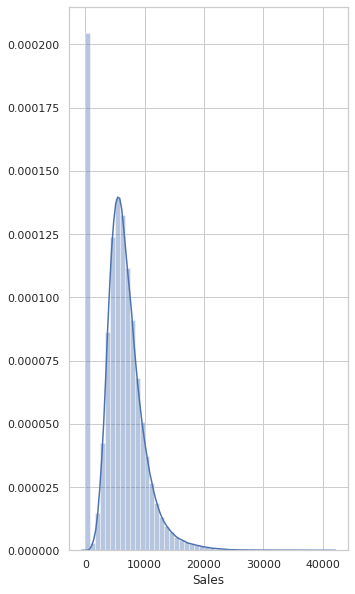

In [11]:
#Find the range of data
plt.figure(figsize=(5,10))
sns.set(style="whitegrid")
sns.distplot(train_data["Sales"])

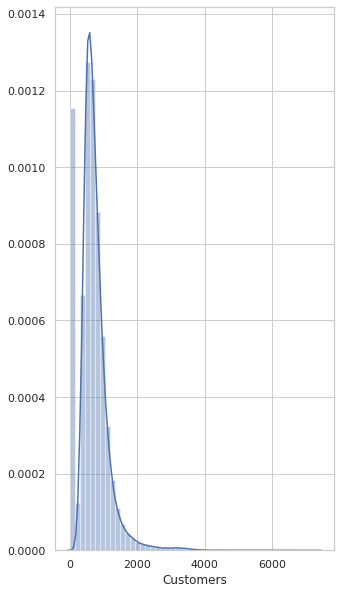

In [12]:
#Find the range of the data
plt.figure(figsize=(5,10))
sns.set(style="whitegrid")
sns.distplot(train_data["Customers"])

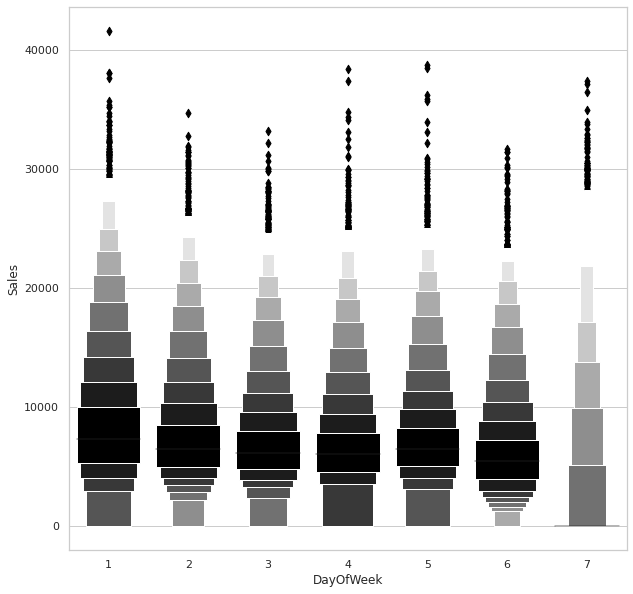

In [13]:
plt.figure(figsize=(10,10))
sns.set(style="whitegrid")
sns.boxenplot(data=train_data,scale="linear",x="DayOfWeek",y="Sales",color="Black")

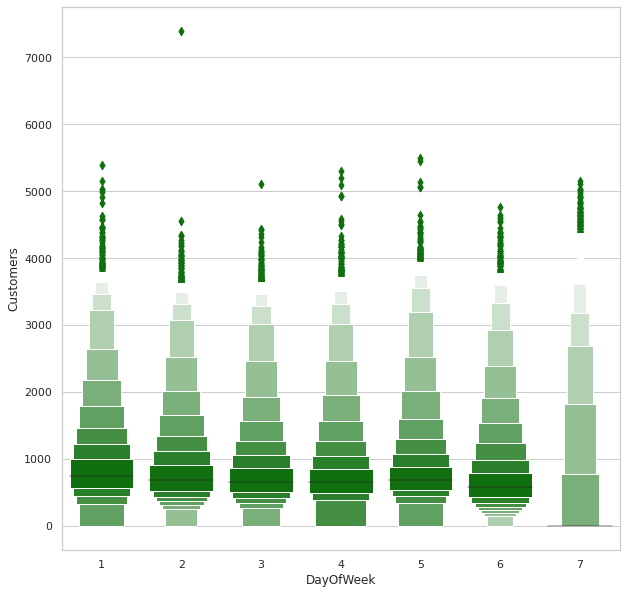

In [14]:
plt.figure(figsize=(10,10))
sns.set(style="whitegrid")
sns.boxenplot(y="Customers", x="DayOfWeek",data=train_data, scale="linear",color="Green")

This data, contains many outliers, but these might have been caused to the surge of customers during a festival or Holiday, or due to an effective promo. 
Below we are handle the outliers

In [15]:
#Treating the outliers 
  # a function for replacing outliers with the median, used when there's too many outliers in a feature
def replace_outlier_with_median(dataFrame, feature):
    Q1 = dataFrame[feature].quantile(0.25)
    Q3 = dataFrame[feature].quantile(0.75)
    median = dataFrame[feature].quantile(0.50)

    IQR = Q3 - Q1

    upper_whisker = Q3 + (1.5 * IQR)
    lower_whisker = Q1 - (1.5 * IQR)

    dataFrame[feature] = np.where(dataFrame[feature] > upper_whisker, median, dataFrame[feature])
    dataFrame[feature] = np.where(dataFrame[feature] < lower_whisker, median, dataFrame[feature])

In [16]:
replace_outlier_with_median(train_data, 'Sales')

In [17]:
replace_outlier_with_median(train_data, 'Customers')

1.3 **Feature Engeneering**

Generating new features from already existing features. 



In [18]:
train_data

,Weekdays,Weeks,Months,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Store-1,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,23,6,867,3,6/3/2015,5608.0,469.0,1,1,0.0,0,867,d,c,21810.0,9.0,2012.0,0,0.0,0.0,"Jan,Apr,Jul,Oct"
1,1,23,6,868,3,6/3/2015,13500.0,816.0,1,1,0.0,0,868,d,c,1360.0,8.0,2005.0,1,10.0,2014.0,"Jan,Apr,Jul,Oct"
2,1,23,6,869,3,6/3/2015,7007.0,932.0,1,1,0.0,0,869,c,a,230.0,10.0,2001.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,1,23,6,870,3,6/3/2015,7911.0,971.0,1,1,0.0,0,870,a,a,780.0,4.0,2009.0,0,0.0,0.0,"Jan,Apr,Jul,Oct"
4,1,23,6,871,3,6/3/2015,9198.0,678.0,1,1,0.0,0,871,d,c,10620.0,0.0,0.0,0,0.0,0.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1,23,6,862,3,6/3/2015,10053.0,1227.0,1,1,0.0,0,862,a,c,2840.0,3.0,2010.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1017205,1,23,6,863,3,6/3/2015,8949.0,1043.0,1,1,0.0,0,863,a,c,21370.0,11.0,2010.0,0,0.0,0.0,"Jan,Apr,Jul,Oct"
1017206,1,23,6,864,3,6/3/2015,6076.0,780.0,1,1,0.0,1,864,a,a,1020.0,10.0,2012.0,1,45.0,2009.0,"Feb,May,Aug,Nov"
1017207,1,23,6,865,3,6/3/2015,11384.0,817.0,1,1,0.0,0,865,d,c,2640.0,0.0,0.0,0,0.0,0.0,"Jan,Apr,Jul,Oct"


In [19]:
#Adding salespercustomer column
train_data['SalesperCustomer']=train_data['Sales']/train_data['Customers']

In [20]:
train_data["Date"]=pd.to_datetime(train_data["Date"])
train_data['Year']=train_data.Date.dt.year
train_data['Day']=train_data.Date.dt.day

In [21]:
#Now we delete the date column since we have its year, months and day
del train_data["Date"]

In [22]:
train_data.columns

Index(['Weekdays', 'Weeks', 'Months', 'Store', 'DayOfWeek', 'Sales',
       'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'Store-1', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
       'SalesperCustomer', 'Year', 'Day'],
      dtype='object')

In [23]:
train_data['CompetitionOpenSince'] = np.where((train_data['CompetitionOpenSinceMonth']==0) & (train_data['CompetitionOpenSinceYear']==0) , 0,(train_data.Months - train_data.CompetitionOpenSinceMonth) + 
                                       (12 * (train_data.Year - train_data.CompetitionOpenSinceYear)) )


In [24]:
#now that CompetitionOpenSince is created 
#we can get rid of `CompetitionOpenSinceYear` and `CompeitionOpenSinceMonth`
del train_data['CompetitionOpenSinceYear']
del train_data['CompetitionOpenSinceMonth']

In [25]:
train_data

,Weekdays,Weeks,Months,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Store-1,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,SalesperCustomer,Year,Day,CompetitionOpenSince
0,1,23,6,867,3,5608.0,469.0,1,1,0.0,0,867,d,c,21810.0,0,0.0,0.0,"Jan,Apr,Jul,Oct",11.957356,2015,3,33.0
1,1,23,6,868,3,13500.0,816.0,1,1,0.0,0,868,d,c,1360.0,1,10.0,2014.0,"Jan,Apr,Jul,Oct",16.544118,2015,3,118.0
2,1,23,6,869,3,7007.0,932.0,1,1,0.0,0,869,c,a,230.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",7.518240,2015,3,164.0
3,1,23,6,870,3,7911.0,971.0,1,1,0.0,0,870,a,a,780.0,0,0.0,0.0,"Jan,Apr,Jul,Oct",8.147271,2015,3,74.0
4,1,23,6,871,3,9198.0,678.0,1,1,0.0,0,871,d,c,10620.0,0,0.0,0.0,"Jan,Apr,Jul,Oct",13.566372,2015,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1,23,6,862,3,10053.0,1227.0,1,1,0.0,0,862,a,c,2840.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",8.193154,2015,3,63.0
1017205,1,23,6,863,3,8949.0,1043.0,1,1,0.0,0,863,a,c,21370.0,0,0.0,0.0,"Jan,Apr,Jul,Oct",8.580058,2015,3,55.0
1017206,1,23,6,864,3,6076.0,780.0,1,1,0.0,1,864,a,a,1020.0,1,45.0,2009.0,"Feb,May,Aug,Nov",7.789744,2015,3,32.0
1017207,1,23,6,865,3,11384.0,817.0,1,1,0.0,0,865,d,c,2640.0,0,0.0,0.0,"Jan,Apr,Jul,Oct",13.933905,2015,3,0.0


* I think it's always better when working with decision tree based models to have dummy variables instead of categorical with different levels, because this alters the bias of the algorithm who will favor a higher weight to the categories like 4 and deprioritize levels like 1. And this problem could rise in the variables Assortment and StoreType and PromoInterval. So far those are the codes we have for each variable:

* That's why i use the get_dummies function to instead do a binary encoding and prevent this.

In [26]:
train_data=pd.get_dummies(train_data, columns=["Assortment", "StoreType","PromoInterval"], prefix=["is_Assortment", "is_StoreType","is_PromoInteval"])

In [27]:
train_data

,Weekdays,Weeks,Months,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Store-1,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,SalesperCustomer,Year,Day,CompetitionOpenSince,is_Assortment_a,is_Assortment_b,is_Assortment_c,is_StoreType_a,is_StoreType_b,is_StoreType_c,is_StoreType_d,"is_PromoInteval_Feb,May,Aug,Nov","is_PromoInteval_Jan,Apr,Jul,Oct","is_PromoInteval_Mar,Jun,Sept,Dec"
0,1,23,6,867,3,5608.0,469.0,1,1,0.0,0,867,21810.0,0,0.0,0.0,11.957356,2015,3,33.0,0,0,1,0,0,0,1,0,1,0
1,1,23,6,868,3,13500.0,816.0,1,1,0.0,0,868,1360.0,1,10.0,2014.0,16.544118,2015,3,118.0,0,0,1,0,0,0,1,0,1,0
2,1,23,6,869,3,7007.0,932.0,1,1,0.0,0,869,230.0,1,14.0,2011.0,7.518240,2015,3,164.0,1,0,0,0,0,1,0,0,1,0
3,1,23,6,870,3,7911.0,971.0,1,1,0.0,0,870,780.0,0,0.0,0.0,8.147271,2015,3,74.0,1,0,0,1,0,0,0,0,1,0
4,1,23,6,871,3,9198.0,678.0,1,1,0.0,0,871,10620.0,0,0.0,0.0,13.566372,2015,3,0.0,0,0,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1,23,6,862,3,10053.0,1227.0,1,1,0.0,0,862,2840.0,1,14.0,2011.0,8.193154,2015,3,63.0,0,0,1,1,0,0,0,0,1,0
1017205,1,23,6,863,3,8949.0,1043.0,1,1,0.0,0,863,21370.0,0,0.0,0.0,8.580058,2015,3,55.0,0,0,1,1,0,0,0,0,1,0
1017206,1,23,6,864,3,6076.0,780.0,1,1,0.0,1,864,1020.0,1,45.0,2009.0,7.789744,2015,3,32.0,1,0,0,1,0,0,0,1,0,0
1017207,1,23,6,865,3,11384.0,817.0,1,1,0.0,0,865,2640.0,0,0.0,0.0,13.933905,2015,3,0.0,0,0,1,0,0,0,1,0,1,0


1.4 **Data Scaling and Data Encoding**

In [28]:
train_data.dtypes

Weekdays                              int64
Weeks                                 int64
Months                                int64
Store                                 int64
DayOfWeek                             int64
Sales                               float64
Customers                           float64
Open                                  int64
Promo                                 int64
StateHoliday                        float64
SchoolHoliday                         int64
Store-1                               int64
CompetitionDistance                 float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
SalesperCustomer                    float64
Year                                  int64
Day                                   int64
CompetitionOpenSince                float64
is_Assortment_a                       uint8
is_Assortment_b                       uint8
is_Assortment_c                 

So far we have taken care of the missing values and the categorical (string) variables in the data. Next we will work with the continuous variables. Often the continuous variables in the data have different scales, for instance, a variable V1 can have a range from 0 to 1 while another variable can have a range from 0-1000.

Based on the type of model you are building, you will have to normalize the data in such a way that the range of all the variables is almost similar. You can do this easily in python using the StandardScaler function.
For this project we will be using Random Forest Regressor

**2. Building models with sklearn pipelines**

In [29]:
## separate the independent and target variable 
features = train_data.drop(['Customers', 'Sales', 'SalesperCustomer'], axis = 1) 
#a rule of thumb is to transform my target value to log if i see the values are very dispersed which is the case
#and then of course revert them with np.exp to their real values
targets=np.log(train_data.Sales)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


**Developing The Model: Shuffle and Split Data with Cross Validation, Grid Search and Fitting the model:**

A crucial Step in Machine Learning is to make sure your model is robust by testing it on a small part of your dataset we call here train_test set which is usually divided 80% training and 20% validation.

In [30]:
X_train, X_train_test, y_train, y_train_test = model_selection.train_test_split(features, targets, test_size=0.20, random_state=15)
print ("Training and testing split was successful.")

Training and testing split was successful.


In [31]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [ ]:
del X_train['index']

In [34]:
y_train = pd.DataFrame(y_train)
y_train = y_train.reset_index()

In [35]:
del y_train['index']

In [ ]:
clean_dataset(y_train)

In [37]:
def _assert_all_finite(X):
    """Like assert_all_finite, but only for ndarray."""
    X = np.asanyarray(X)
    # First try an O(n) time, O(1) space solution for the common case that
    # everything is finite; fall back to O(n) space np.isfinite to prevent
    # false positives from overflow in sum method.
    if (X.dtype.char in np.typecodes['AllFloat'] and not np.isfinite(X.sum())
            and not np.isfinite(X).all()):
        raise ValueError("Input contains NaN, infinity"
                         " or a value too large for %r." % X.dtype)

In [ ]:
#This is the check on which it fails:
_assert_all_finite(y_train)

In [ ]:
y_train

After finding which data has the problem, below is a loop to get which problem is it.

In [ ]:
print(y_train.shape)
index = 0
for i in y_train:
    if not np.isfinite(i):
        print(index, i)
    index +=1


In [41]:
y_train.replace([np.inf, -np.inf], np.nan, inplace=True)

In [51]:
y_train_test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [42]:
y_train.fillna(8.970432, inplace=True)

In [52]:
y_train_test.fillna(8.970432, inplace=True)

In [43]:
#convert dataframe to numpy array
y_train = y_train.to_numpy()

In [ ]:
y = y_train.ravel()
y_train = np.array(y).astype(int)

**Setting up the RandomForestRegressor object**

In [55]:
def rmspe(y, result):
    rmspe = np.sqrt(np.mean( (y - result)**2 ))
    return rmspe

In [45]:
RFR = RandomForestRegressor(n_estimators=10, 
                             criterion='mse', 
                             max_depth=5, 
                             min_samples_split=2, 
                             min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_features='auto', 
                             max_leaf_nodes=None, 
                             min_impurity_decrease=0.0, 
                             min_impurity_split=None, 
                             bootstrap=True, 
                             oob_score=False,
                             n_jobs=4,
                             random_state=31, 
                             verbose=0, 
                             warm_start=False)
RFR.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=4, oob_score=False,
                      random_state=31, verbose=0, warm_start=False)

In [66]:

params = {'max_depth':(4,6,8,10,12,14,16,20),
         'n_estimators':(4,8,16,24,48,72,96,128),
         'min_samples_split':(2,4,6,8,10)}
#scoring_fnc = metrics.make_scorer(rmspe)
#the dimensionality is high, the number of combinations we have to search is enormous, using RandomizedSearchCV 
# is a better option then GridSearchCV
grid = model_selection.RandomizedSearchCV(estimator=RFR,param_distributions=params,cv=5,) 
#choosing 10 K-Folds makes sure i went through all of the data and didn't miss any pattern.(takes time to run but is worth doing it)
grid.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse', max_depth=5,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=10, n_jobs=4,
                                                   oob_score=False,
       

In [ ]:
#This is the best combination i got from what i propose to try out with a (mse) score of 0.855 which is quite good
#grid.best_params_,grid.best_score_
#MY BEST PARAMS ARE :n_estimators=128,max_depth=20,min_samples_split=10
grid.best_params_

**Test our RF on the validation set:**

In [62]:
#with the optimal parameters i got let's see how it behaves with the validation set
rfr_val=RandomForestRegressor(n_estimators=96, 
                             criterion='mse', 
                             max_depth=10, 
                             min_samples_split=10, 
                             min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_features='auto', 
                             max_leaf_nodes=None, 
                             min_impurity_decrease=0.0, 
                             min_impurity_split=None, 
                             bootstrap=True, 
                             oob_score=False,
                             n_jobs=4, #setting n_jobs to 4 makes sure you're using the full potential of the machine you're running the training on
                             random_state=None, 
                             verbose=0, 
                             warm_start=False)
model_RF_test=rfr_val.fit(X_train,y_train)

In [63]:
result=model_RF_test.predict(X_train_test)

(array([2.50000e+01, 1.00000e+00, 1.92000e+02, 4.12000e+02, 4.89000e+02,
        8.38300e+03, 1.09371e+05, 5.86030e+04, 2.25670e+04, 3.39900e+03]),
 array([6.17849046, 6.46037768, 6.7422649 , 7.02415212, 7.30603933,
        7.58792655, 7.86981377, 8.15170099, 8.43358821, 8.71547542,
        8.99736264]),
 <a list of 10 Patch objects>)

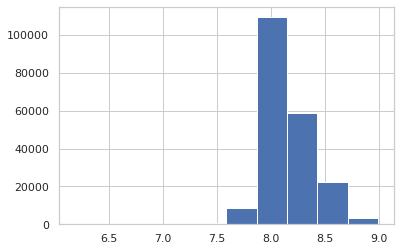

In [64]:
plt.hist(result)

In [65]:
mean_squared_error(y_train_test,result)

0.46075121429922067